📊 Session Info:
   session_id              session_start                session_end  \
0           0 2025-09-11 18:04:58.393468 2025-09-11 18:07:36.508890   
1           1 2025-09-12 00:10:39.999553 2025-09-12 00:17:52.305095   
2           2 2025-09-16 09:53:26.244660 2025-09-16 09:55:15.503289   

   message_count       session_duration  duration_minutes  
0              7 0 days 00:02:38.115422          2.635257  
1             16 0 days 00:07:12.305542          7.205092  
2              4 0 days 00:01:49.258629          1.820977  


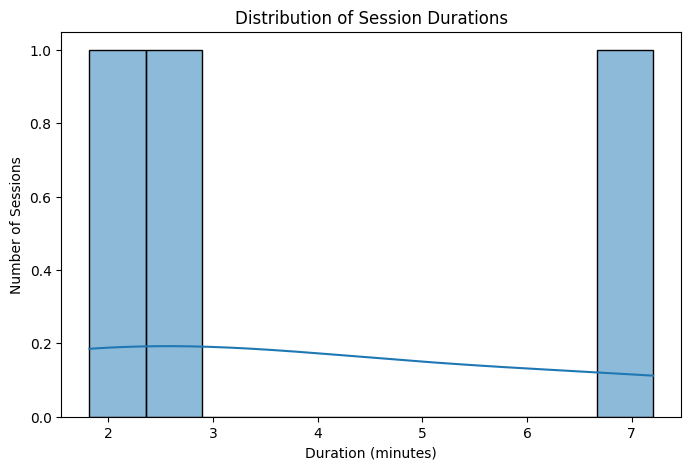

✅ JSON report saved successfully.
✅ All Phase3 reports saved in ../results/reports/


In [1]:
# ===========================================
# Phase 3 – Logging, Visualization & Reports
# ===========================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from datetime import datetime
import ast
import json
import os

# =========================
# Ensure reports directory exists
# =========================
os.makedirs("../results/reports", exist_ok=True)

# =========================
# Load chatbot logs
# =========================
df = pd.read_csv("../results/logs/chatbot_logs.csv", parse_dates=["timestamp"])

# =========================
# Parse emotions & distress safely
# =========================
def parse_column(x):
    if pd.isna(x) or x == "":
        return []
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except Exception:
            return []
    return x

df["emotions"] = df["emotions"].apply(parse_column)
df["distress"] = df["distress"].apply(parse_column)

# =========================
# Add session handling
# =========================
session_timeout = pd.Timedelta(minutes=30)
df = df.sort_values("timestamp").reset_index(drop=True)
sessions = []
current_session = 0
last_time = df.loc[0, "timestamp"]

for i, row in df.iterrows():
    if row["timestamp"] - last_time > session_timeout:
        current_session += 1
    sessions.append(current_session)
    last_time = row["timestamp"]

df["session_id"] = sessions

# =========================
# Session durations
# =========================
session_info = df.groupby("session_id").agg(
    session_start=("timestamp", "min"),
    session_end=("timestamp", "max"),
    message_count=("user_input", "count")
).reset_index()

session_info["session_duration"] = session_info["session_end"] - session_info["session_start"]
session_info["duration_minutes"] = session_info["session_duration"].dt.total_seconds() / 60

print("📊 Session Info:")
print(session_info)

# =========================
# Static Visualization (Matplotlib/Seaborn)
# =========================
plt.figure(figsize=(8,5))
sns.histplot(session_info["duration_minutes"], bins=10, kde=True)
plt.title("Distribution of Session Durations")
plt.xlabel("Duration (minutes)")
plt.ylabel("Number of Sessions")
plt.show()

# =========================
# Interactive Visualizations (Plotly)
# =========================
fig = px.histogram(
    session_info,
    x="duration_minutes",
    nbins=10,
    title="Interactive Distribution of Session Durations",
    labels={"duration_minutes": "Duration (minutes)"},
    color_discrete_sequence=["#1f77b4"]
)
fig.update_layout(bargap=0.1)
fig.show()

# Gantt-style session timeline
timeline_data = [
    dict(Task=f"Session {row['session_id']}", Start=row["session_start"], Finish=row["session_end"])
    for _, row in session_info.iterrows()
]

fig = ff.create_gantt(
    timeline_data,
    index_col="Task",
    show_colorbar=True,
    group_tasks=True,
    title="Session Timelines"
)
fig.update_layout(xaxis_title="Time", yaxis_title="Sessions")
fig.show()

# Average session duration indicator
avg_dur = session_info["duration_minutes"].mean()
longest_dur = session_info["duration_minutes"].max()
shortest_dur = session_info["duration_minutes"].min()

fig = go.Figure()
fig.add_trace(go.Indicator(
    mode="number+delta",
    value=avg_dur,
    delta={'reference': shortest_dur, 'increasing': {'color': "green"}},
    title={"text": "Average Session Duration (min)"}
))
fig.show()

# =========================
# Emotion Frequency Analysis
# =========================
all_emotions = []
for row in df["emotions"]:
    if isinstance(row, list):
        for e in row:
            if isinstance(e, (list, tuple)) and len(e) > 0:
                all_emotions.append(e[0])

emotion_counts = pd.Series(all_emotions).value_counts().reset_index()
emotion_counts.columns = ["emotion", "count"]

fig = px.bar(
    emotion_counts.head(10),
    x="emotion", y="count",
    title="Top 10 Emotions Detected",
    text="count",
    color="emotion"
)
fig.show()

# =========================
# Distress Frequency Analysis
# =========================
all_distress = []
for row in df["distress"]:
    if isinstance(row, list):
        for d in row:
            if isinstance(d, (list, tuple)) and len(d) > 0:
                all_distress.append(d[0])

distress_counts = pd.Series(all_distress).value_counts().reset_index()
distress_counts.columns = ["distress", "count"]

fig = px.pie(
    distress_counts,
    names="distress", values="count",
    title="Distribution of Distress Conditions"
)
fig.show()

# =========================
# Combine key charts into interactive dashboard
# =========================
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=("Session Durations", "Session Timelines", "Emotions", "Distress"),
    specs=[[{"type":"xy"}, {"type":"xy"}],
           [{"type":"bar"}, {"type":"domain"}]]
)

# Session duration histogram
fig.add_trace(go.Histogram(x=session_info["duration_minutes"], name="Durations"), row=1, col=1)

# Session timelines
for _, row in session_info.iterrows():
    fig.add_trace(
        go.Bar(
            x=[(row["session_end"]-row["session_start"]).total_seconds()/60],
            y=[f"Session {row['session_id']}"],
            orientation="h",
            name=f"Session {row['session_id']}"
        ), row=1, col=2
    )

# Emotion counts
fig.add_trace(go.Bar(x=emotion_counts["emotion"], y=emotion_counts["count"], name="Emotions"), row=2, col=1)

# Distress pie
fig.add_trace(go.Pie(labels=distress_counts["distress"], values=distress_counts["count"]), row=2, col=2)

fig.update_layout(title_text="Chatbot Analytics Dashboard", showlegend=False)
fig.show()

# =========================
# Save all reports in ../results/reports/
# =========================
session_info.to_csv("../results/reports/session_info.csv", index=False)
emotion_counts.to_csv("../results/reports/emotion_counts.csv", index=False)
distress_counts.to_csv("../results/reports/distress_counts.csv", index=False)

# Convert timestamps and timedelta to strings / numbers for JSON
session_info_serializable = session_info.copy()
session_info_serializable["session_start"] = session_info_serializable["session_start"].astype(str)
session_info_serializable["session_end"] = session_info_serializable["session_end"].astype(str)
session_info_serializable["session_duration"] = session_info_serializable["session_duration"].apply(lambda x: str(x))

# Combined JSON summary
report = {
    "total_interactions": int(len(df)),
    "top_emotions": emotion_counts.head(10).to_dict('records'),
    "top_distress": distress_counts.head(10).to_dict('records'),
    "session_stats": session_info_serializable.to_dict('records')
}

# Save JSON
with open("../results/reports/phase3_summary.json", "w") as f:
    import json
    json.dump(report, f, indent=2)

print("✅ JSON report saved successfully.")

# Save interactive dashboard
fig.write_html("../results/reports/chatbot_dashboard.html")
print("✅ All Phase3 reports saved in ../results/reports/")


In [32]:
# ===========================================
# Phase 3 – Logging, Visualization & Reports (Flashcard Version)
# ===========================================

import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
import ast, json, os

# =========================
# Paths
# =========================
results_dir = os.path.abspath("../results")
reports_dir = os.path.join(results_dir, "reports")
os.makedirs(reports_dir, exist_ok=True)

logs_path = os.path.join(results_dir, "logs", "chatbot_logs.csv")

# =========================
# Load chatbot logs
# =========================
df = pd.read_csv(logs_path, parse_dates=["timestamp"])

# =========================
# Safe parse of emotions & distress
# =========================
def parse_column(x):
    if pd.isna(x) or x == "":
        return []
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except Exception:
            return []
    return x

df["emotions"] = df["emotions"].apply(parse_column)
df["distress"] = df["distress"].apply(parse_column)

# =========================
# Session handling (30 min timeout)
# =========================
session_timeout = pd.Timedelta(minutes=30)
df = df.sort_values("timestamp").reset_index(drop=True)

sessions, current_session, last_time = [], 0, df.loc[0, "timestamp"]

for _, row in df.iterrows():
    if row["timestamp"] - last_time > session_timeout:
        current_session += 1
    sessions.append(current_session)
    last_time = row["timestamp"]

df["session_id"] = sessions

# Store session messages for interactivity
sessions_messages = {
    s: df[df["session_id"] == s][["timestamp", "user_input", "emotions", "distress"]].to_dict("records")
    for s in df["session_id"].unique()
}

# =========================
# Session info
# =========================
session_info = df.groupby("session_id").agg(
    session_start=("timestamp", "min"),
    session_end=("timestamp", "max"),
    message_count=("user_input", "count")
).reset_index()

session_info["session_duration"] = session_info["session_end"] - session_info["session_start"]
session_info["duration_minutes"] = session_info["session_duration"].dt.total_seconds() / 60

# =========================
# Helpers for emotion & distress counts
# =========================
def flatten_first_element(lst):
    return [e[0] for row in lst for e in row if isinstance(e, (list, tuple)) and len(e) > 0]

def compute_counts(df_subset):
    emotions = flatten_first_element(df_subset["emotions"])
    distress = flatten_first_element(df_subset["distress"])
    emo_counts = pd.Series(emotions).value_counts().reset_index()
    emo_counts.columns = ["emotion", "count"]
    dist_counts = pd.Series(distress).value_counts().reset_index()
    dist_counts.columns = ["distress", "count"]
    return emo_counts, dist_counts

# =========================
# Dashboard generator (flashcard instead of table)
# =========================
def generate_dashboard(df_sessions, title, save_path, sessions_messages, emotion_counts, distress_counts):
    # Convert session keys to strings for JS
    sessions_messages_fixed = {
        str(k): [
            {
                "timestamp": str(m["timestamp"]),
                "user_input": m["user_input"],
                "emotions": m["emotions"],
                "distress": m["distress"],
            }
            for m in v
        ]
        for k, v in sessions_messages.items()
    }

    # Histogram of session durations
    hist_fig = px.histogram(df_sessions, x="duration_minutes", nbins=10,
                            title="Session Duration Distribution",
                            labels={"duration_minutes": "Minutes"})

    # Timeline chart
    timeline_fig = go.Figure()
    for _, row in df_sessions.iterrows():
        timeline_fig.add_trace(go.Scatter(
            x=[row["session_start"], row["session_end"]],
            y=[f"Session {row['session_id']}"]*2,
            mode="lines",
            line=dict(width=10),
            name=f"Session {row['session_id']}",
            customdata=[[str(row["session_id"]), str(row["session_id"])]],
            hovertemplate="Session %{y}<br>Start: %{x}<extra></extra>"
        ))

    timeline_fig.update_layout(title="Session Timelines",
        xaxis=dict(rangeslider=dict(visible=True), type="date"),
        yaxis=dict(title="Sessions"))

    # Average session duration indicator
    avg_dur = df_sessions["duration_minutes"].mean()
    indicator_fig = go.Figure(go.Indicator(
        mode="number",
        value=avg_dur,
        title={"text": "Avg Duration (min)"}
    ))

    # Emotion bar & distress pie
    emo_fig = go.Figure(go.Bar(x=emotion_counts["emotion"], y=emotion_counts["count"]))
    dist_fig = go.Figure(go.Pie(labels=distress_counts["distress"], values=distress_counts["count"]))

    # Dashboard layout (2 per row grid, no empty tables)
    fig = make_subplots(
        rows=3, cols=2,
        subplot_titles=("Durations", "Timelines", "Avg Duration",
                        "Emotions", "Distress", "Flashcards"),
        specs=[[{"type":"xy"},{"type":"xy"}],
               [{"type":"indicator"},{"type":"bar"}],
               [{"type":"domain"},{"type":"domain"}]]
    )

    # Row 1
    for t in hist_fig.data: fig.add_trace(t, row=1, col=1)
    for t in timeline_fig.data: fig.add_trace(t, row=1, col=2)

    # Row 2
    for t in indicator_fig.data: fig.add_trace(t, row=2, col=1)
    for t in emo_fig.data: fig.add_trace(t, row=2, col=2)

    # Row 3
    for t in dist_fig.data: fig.add_trace(t, row=3, col=1)

    fig.update_layout(title_text=title, height=1200)

    # =========================
    # Inject Flashcard container (custom HTML)
    # =========================
    js_code = f"""
<script>
const plot = document.getElementsByClassName('js-plotly-plot')[0];
const sessions_messages = {json.dumps(sessions_messages_fixed)};

// Create overlay container
let overlay = document.createElement("div");
overlay.id = "flashOverlay";
overlay.style.position = "fixed";
overlay.style.top = "0";
overlay.style.left = "0";
overlay.style.width = "100%";
overlay.style.height = "100%";
overlay.style.backgroundColor = "rgba(0,0,0,0.5)";
overlay.style.display = "none";
overlay.style.alignItems = "center";
overlay.style.justifyContent = "center";
overlay.style.zIndex = "1000";
document.body.appendChild(overlay);

// Flashcard container
let flashDiv = document.createElement("div");
flashDiv.id = "flashcard";
flashDiv.style.border = "1px solid #ddd";
flashDiv.style.borderRadius = "10px";
flashDiv.style.boxShadow = "0 2px 6px rgba(0,0,0,0.25)";
flashDiv.style.padding = "20px";
flashDiv.style.width = "60%";
flashDiv.style.maxHeight = "80%";
flashDiv.style.overflowY = "auto";
flashDiv.style.backgroundColor = "#fff";
flashDiv.style.position = "relative";
overlay.appendChild(flashDiv);

// Close button
let closeBtn = document.createElement("span");
closeBtn.innerHTML = "&times;";
closeBtn.style.position = "absolute";
closeBtn.style.top = "10px";
closeBtn.style.right = "15px";
closeBtn.style.cursor = "pointer";
closeBtn.style.fontSize = "22px";
closeBtn.style.fontWeight = "bold";
flashDiv.appendChild(closeBtn);

closeBtn.onclick = () => {{ overlay.style.display = "none"; }};
overlay.onclick = (e) => {{ if (e.target === overlay) overlay.style.display = "none"; }};

// Robust frequency counter
function countFrequencies(arr) {{
    let freq = {{}};
    arr.forEach(v => {{
        if (Array.isArray(v)) {{
            // Case 1: nested array [[label, score], ...]
            v.forEach(e => {{
                let label = Array.isArray(e) ? e[0] : e;
                freq[label] = (freq[label] || 0) + 1;
            }});
        }} else {{
            // Case 2: flat array ["label1", "label2"]
            freq[v] = (freq[v] || 0) + 1;
        }}
    }});
    return freq;
}}

// On clicking timeline session
plot.on('plotly_click', function(data){{
    const session_id = String(data.points[0].customdata[0]);
    const messages = sessions_messages[session_id];
    if (!messages) return;

    flashDiv.innerHTML = "";
    flashDiv.appendChild(closeBtn);

    let header = document.createElement("h3");
    header.textContent = "Session " + session_id;
    flashDiv.appendChild(header);

    let allEmo = [], allDist = [];
    messages.forEach(m => {{
        if (Array.isArray(m.emotions)) allEmo.push(m.emotions);
        if (Array.isArray(m.distress)) allDist.push(m.distress);
    }});
    let emoCounts = countFrequencies(allEmo);
    let distCounts = countFrequencies(allDist);

    let summary = document.createElement("div");
    summary.innerHTML = `
        <h4>Summary</h4>
        <p><b>Start:</b> ${{messages[0].timestamp}}</p>
        <p><b>End:</b> ${{messages[messages.length-1].timestamp}}</p>
        <p><b>Messages:</b> ${{messages.length}}</p>
        <p><b>Emotions Occurred:</b></p>
        <ul>${{
            Object.entries(emoCounts).map(([k,v]) => `<li>${{k}}: ${{v}}</li>`).join("")
        }}</ul>
        <p><b>Distress Conditions Occurred:</b></p>
        <ul>${{
            Object.entries(distCounts).map(([k,v]) => `<li>${{k}}: ${{v}}</li>`).join("")
        }}</ul>
    `;
    flashDiv.appendChild(summary);

    // Chat log
    let log = document.createElement("div");
    log.style.marginTop = "15px";
    log.innerHTML = "<h4>Chat Log</h4>";

    let chatBox = document.createElement("div");
    chatBox.style.display = "flex";
    chatBox.style.flexDirection = "column";
    chatBox.style.gap = "10px";
    chatBox.style.padding = "10px";
    chatBox.style.border = "1px solid #eee";
    chatBox.style.borderRadius = "8px";
    chatBox.style.backgroundColor = "#fafafa";
    chatBox.style.maxHeight = "300px";
    chatBox.style.overflowY = "auto";

    messages.forEach(m => {{
        let bubble = document.createElement("div");
        bubble.style.padding = "8px 12px";
        bubble.style.borderRadius = "8px";
        bubble.style.maxWidth = "75%";
        bubble.style.wordWrap = "break-word";
        bubble.style.fontSize = "14px";
        bubble.style.lineHeight = "1.4";
        bubble.style.boxShadow = "0 1px 3px rgba(0,0,0,0.1)";

        if (m.sender === "user") {{
            bubble.style.alignSelf = "flex-end";
            bubble.style.backgroundColor = "#d1e7dd";
        }} else {{
            bubble.style.alignSelf = "flex-start";
            bubble.style.backgroundColor = "#f8d7da";
        }}

        // Show only labels
        const emoLabels = Array.isArray(m.emotions) ? m.emotions.map(e => Array.isArray(e)? e[0]: e).join(", ") : "";
        const distLabels = Array.isArray(m.distress) ? m.distress.map(e => Array.isArray(e)? e[0]: e).join(", ") : "";

        bubble.innerHTML = `<b>[${{m.timestamp}}]</b><br>${{m.user_input || m.bot_response}}<br>
            <small>Emotions: ${{emoLabels}} | Distress: ${{distLabels}}</small>`;

        chatBox.appendChild(bubble);
    }});

    log.appendChild(chatBox);
    flashDiv.appendChild(log);

    overlay.style.display = "flex";
}});
</script>
"""



    fig.write_html(save_path, include_plotlyjs='cdn', full_html=True)
    with open(save_path, "a") as f: f.write(js_code)
    print(f"✅ Dashboard with flashcards saved: {save_path}")


# =========================
# Generate dashboards
# =========================
# Overall
overall_emo, overall_dist = compute_counts(df)
generate_dashboard(session_info, "Overall Sessions Dashboard",
                   os.path.join(reports_dir, "overall_sessions_dashboard.html"),
                   sessions_messages, overall_emo, overall_dist)

# Present session
latest_session_id = session_info["session_id"].max()
present_df = df[df["session_id"] == latest_session_id]
present_info = session_info[session_info["session_id"] == latest_session_id]
present_emo, present_dist = compute_counts(present_df)

generate_dashboard(present_info, f"Present Session Dashboard (Session {latest_session_id})",
                   os.path.join(reports_dir, "present_session_dashboard.html"),
                   sessions_messages, present_emo, present_dist)


✅ Dashboard with flashcards saved: c:\Users\rijju\Desktop\mental-health-chatbot\results\reports\overall_sessions_dashboard.html
✅ Dashboard with flashcards saved: c:\Users\rijju\Desktop\mental-health-chatbot\results\reports\present_session_dashboard.html


In [37]:
# ===========================================
# Phase 3 – Logging, Visualization & Reports (Dynamic & Flashcard Version with JSON)
# ===========================================

import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
import ast, json, os

# =========================
# Paths
# =========================
results_dir = os.path.abspath("../results")
reports_dir = os.path.join(results_dir, "reports")
os.makedirs(reports_dir, exist_ok=True)

logs_path = os.path.join(results_dir, "logs", "chatbot_logs.csv")

# =========================
# Safe parse of emotions & distress
# =========================
def parse_column(x):
    if pd.isna(x) or x == "":
        return []
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except Exception:
            return []
    return x

# =========================
# Helpers for emotion & distress counts
# =========================
def flatten_first_element(lst):
    return [e[0] for row in lst for e in row if isinstance(e, (list, tuple)) and len(e) > 0]

def compute_counts(df_subset):
    emotions = flatten_first_element(df_subset["emotions"])
    distress = flatten_first_element(df_subset["distress"])
    emo_counts = pd.Series(emotions).value_counts().reset_index()
    emo_counts.columns = ["emotion", "count"]
    dist_counts = pd.Series(distress).value_counts().reset_index()
    dist_counts.columns = ["distress", "count"]
    return emo_counts, dist_counts

# =========================
# Load chat logs dynamically
# =========================
def load_chat_logs(logs_path):
    df = pd.read_csv(logs_path, parse_dates=["timestamp"])
    df["emotions"] = df["emotions"].apply(parse_column)
    df["distress"] = df["distress"].apply(parse_column)
    
    # Session handling (30 min timeout)
    session_timeout = pd.Timedelta(minutes=30)
    df = df.sort_values("timestamp").reset_index(drop=True)
    sessions, current_session, last_time = [], 0, df.loc[0, "timestamp"]
    for _, row in df.iterrows():
        if row["timestamp"] - last_time > session_timeout:
            current_session += 1
        sessions.append(current_session)
        last_time = row["timestamp"]
    df["session_id"] = sessions
    return df

# =========================
# Save session summary JSON
# =========================
def save_session_summary_json(sessions_messages, save_dir):
    for session_id, messages in sessions_messages.items():
        if not messages:
            continue

        all_emo = [e[0] for row in messages for e in row["emotions"] if isinstance(e, (list, tuple)) and len(e) > 0]
        all_dist = [d[0] for row in messages for d in row["distress"] if isinstance(d, (list, tuple)) and len(d) > 0]

        summary = {
            "session_id": session_id,
            "start_time": str(messages[0]["timestamp"]),
            "end_time": str(messages[-1]["timestamp"]),
            "message_count": len(messages),
            "emotions_count": {k: all_emo.count(k) for k in set(all_emo)},
            "distress_count": {k: all_dist.count(k) for k in set(all_dist)},
            "chat_log": messages
        }

        json_path = os.path.join(save_dir, f"session_{session_id}_summary.json")
        with open(json_path, "w", encoding="utf-8") as f:
            json.dump(summary, f, ensure_ascii=False, indent=2)

# =========================
# Dashboard generator
# =========================
def generate_dashboard(df_sessions, title, save_path, sessions_messages, emotion_counts, distress_counts):
    # Convert session keys to strings for JS
    sessions_messages_fixed = {
        str(k): [
            {
                "timestamp": str(m["timestamp"]),
                "user_input": m.get("user_input",""),
                "bot_response": m.get("bot_response",""),
                "emotions": m["emotions"],
                "distress": m["distress"],
                "sender": m.get("sender","user")
            }
            for m in v
        ]
        for k, v in sessions_messages.items()
    }

    # Create the main figures (Histogram, Timeline, etc.)
    hist_fig = px.histogram(df_sessions, x="duration_minutes", nbins=10,
                            title="Session Duration Distribution",
                            labels={"duration_minutes": "Minutes"})

    timeline_fig = go.Figure()
    for _, row in df_sessions.iterrows():
        timeline_fig.add_trace(go.Scatter(
            x=[row["session_start"], row["session_end"]],
            y=[f"Session {row['session_id']}"]*2,
            mode="lines",
            line=dict(width=10),
            name=f"Session {row['session_id']}",
            customdata=[[str(row["session_id"]), str(row["session_id"])]],
            hovertemplate="Session %{y}<br>Start: %{x}<extra></extra>"
        ))
    timeline_fig.update_layout(
        title="Session Timelines",
        xaxis=dict(rangeslider=dict(visible=True), type="date"),
        yaxis=dict(title="Sessions"),
        showlegend=False
    )

    avg_dur = df_sessions["duration_minutes"].mean()
    indicator_fig = go.Figure(go.Indicator(
        mode="number",
        value=avg_dur,
        title={"text": "Avg Duration (min)"}
    ))

    emo_fig = go.Figure(go.Bar(x=emotion_counts["emotion"], y=emotion_counts["count"]))
    dist_fig = go.Figure(go.Pie(labels=distress_counts["distress"], values=distress_counts["count"]))

    # Dashboard layout
    fig = make_subplots(
        rows=3, cols=2,
        subplot_titles=("Durations", "Timelines", "Avg Duration",
                        "Emotions", "Distress", "Flashcards"),
        specs=[[{"type":"xy"},{"type":"xy"}],
               [{"type":"indicator"},{"type":"xy"}],
               [{"type":"domain"},{"type":"domain"}]]
    )

    for t in hist_fig.data: fig.add_trace(t, row=1, col=1)
    for t in timeline_fig.data: fig.add_trace(t, row=1, col=2)
    for t in indicator_fig.data: fig.add_trace(t, row=2, col=1)
    for t in emo_fig.data: fig.add_trace(t, row=2, col=2)
    for t in dist_fig.data: fig.add_trace(t, row=3, col=1)

    fig.update_layout(title_text=title, height=1200)

    # =========================
    # Add interactive flashcards via JS in HTML
    # =========================
    js_code = f"""
<script>
const sessions_messages = {{json.dumps(sessions_messages_fixed)}};
document.addEventListener("DOMContentLoaded", function(){{
    const plots = document.getElementsByClassName('js-plotly-plot');
    if(plots.length===0) return;
    const plot = plots[0];

    let overlay = document.createElement("div");
    overlay.id = "flashOverlay"; overlay.style.position="fixed"; overlay.style.top="0"; overlay.style.left="0";
    overlay.style.width="100%"; overlay.style.height="100%"; overlay.style.backgroundColor="rgba(0,0,0,0.5)";
    overlay.style.display="none"; overlay.style.alignItems="center"; overlay.style.justifyContent="center"; overlay.style.zIndex="1000";
    document.body.appendChild(overlay);

    let flashDiv = document.createElement("div");
    flashDiv.id="flashcard"; flashDiv.style.border="1px solid #ddd"; flashDiv.style.borderRadius="10px";
    flashDiv.style.boxShadow="0 2px 6px rgba(0,0,0,0.25)"; flashDiv.style.padding="20px"; flashDiv.style.width="60%";
    flashDiv.style.maxHeight="80%"; flashDiv.style.overflowY="auto"; flashDiv.style.backgroundColor="#fff"; flashDiv.style.position="relative";
    overlay.appendChild(flashDiv);

    let closeBtn=document.createElement("span"); closeBtn.innerHTML="&times;";
    closeBtn.style.position="absolute"; closeBtn.style.top="10px"; closeBtn.style.right="15px";
    closeBtn.style.cursor="pointer"; closeBtn.style.fontSize="22px"; closeBtn.style.fontWeight="bold";
    flashDiv.appendChild(closeBtn);
    closeBtn.onclick=()=>{{overlay.style.display="none"}};
    overlay.onclick=(e)=>{{if(e.target===overlay) overlay.style.display="none"}};

    function countFrequencies(arr){{
        let freq={{}};
        arr.forEach(v=>{{
            if(Array.isArray(v)){{
                v.forEach(e=>{{ let label=Array.isArray(e)?e[0]:e; freq[label]=(freq[label]||0)+1;}});
            }} else {{ freq[v]=(freq[v]||0)+1; }}
        }});
        return freq;
    }}

    plot.on('plotly_click', function(data){{
        const session_id=String(data.points[0].customdata[0]);
        const messages=sessions_messages[session_id]; if(!messages) return;

        flashDiv.innerHTML=""; flashDiv.appendChild(closeBtn);
        let header=document.createElement("h3"); header.textContent="Session "+session_id; flashDiv.appendChild(header);

        let allEmo=[], allDist=[];
        messages.forEach(m=>{{if(Array.isArray(m.emotions)) allEmo.push(m.emotions); if(Array.isArray(m.distress)) allDist.push(m.distress);}});
        let emoCounts=countFrequencies(allEmo); let distCounts=countFrequencies(allDist);

        let summary=document.createElement("div");
        summary.innerHTML=`<h4>Summary</h4>
            <p><b>Start:</b>${{messages[0].timestamp}}</p>
            <p><b>End:</b>${{messages[messages.length-1].timestamp}}</p>
            <p><b>Messages:</b>${{messages.length}}</p>
            <p><b>Emotions Occurred:</b><ul>${{Object.entries(emoCounts).map(([k,v])=>`<li>${{k}}: ${{v}}</li>`).join("")}}</ul>
            <p><b>Distress Conditions Occurred:</b><ul>${{Object.entries(distCounts).map(([k,v])=>`<li>${{k}}: ${{v}}</li>`).join("")}}</ul>`;
        flashDiv.appendChild(summary);

        let log=document.createElement("div"); log.style.marginTop="15px"; log.innerHTML="<h4>Chat Log</h4>";
        let chatBox=document.createElement("div"); chatBox.style.display="flex"; chatBox.style.flexDirection="column";
        chatBox.style.gap="10px"; chatBox.style.padding="10px"; chatBox.style.border="1px solid #eee";
        chatBox.style.borderRadius="8px"; chatBox.style.backgroundColor="#fafafa"; chatBox.style.maxHeight="300px"; chatBox.style.overflowY="auto";

        messages.forEach(m=>{{
            let bubble=document.createElement("div");
            bubble.style.padding="8px 12px"; bubble.style.borderRadius="8px"; bubble.style.maxWidth="75%";
            bubble.style.wordWrap="break-word"; bubble.style.fontSize="14px"; bubble.style.lineHeight="1.4";
            bubble.style.boxShadow="0 1px 3px rgba(0,0,0,0.1)";
            if(m.sender==="user"){{ bubble.style.alignSelf="flex-end"; bubble.style.backgroundColor="#d1e7dd"; }}
            else {{ bubble.style.alignSelf="flex-start"; bubble.style.backgroundColor="#f8d7da"; }}
            const emoLabels=Array.isArray(m.emotions)? m.emotions.map(e=>Array.isArray(e)?e[0]:e).join(", "):"";
            const distLabels=Array.isArray(m.distress)? m.distress.map(e=>Array.isArray(e)?e[0]:e).join(", "):"";
            bubble.innerHTML=`<b>[${{m.timestamp}}]</b><br>${{m.user_input||m.bot_response}}<br>
                <small>Emotions: ${{emoLabels}} | Distress: ${{distLabels}}</small>`;
            chatBox.appendChild(bubble);
        }});
        log.appendChild(chatBox); flashDiv.appendChild(log); overlay.style.display="flex";
    }});
}});
</script>
    """

    # Save session summary JSON
    summary_path = save_path.replace(".html", "_session_summary.json")
    with open(summary_path, "w", encoding="utf-8") as f:
        json.dump(sessions_messages_fixed, f, ensure_ascii=False, indent=4)

    # Write HTML dashboard with embedded JS
    fig.write_html(save_path, include_plotlyjs='cdn', full_html=True)
    with open(save_path, "a", encoding="utf-8") as f:
        f.write(js_code)
    print(f"✅ Dashboard with flashcards saved: {save_path}")
    print(f"✅ Session summary saved: {summary_path}")


# =========================
# Main update function
# =========================
def update_dashboards():
    df = load_chat_logs(logs_path)

    # Session info
    session_info = df.groupby("session_id").agg(
        session_start=("timestamp", "min"),
        session_end=("timestamp", "max"),
        message_count=("user_input", "count")
    ).reset_index()
    session_info["session_duration"] = session_info["session_end"] - session_info["session_start"]
    session_info["duration_minutes"] = session_info["session_duration"].dt.total_seconds() / 60

    # Store session messages
    sessions_messages = {
        s: df[df["session_id"] == s][["timestamp","user_input","bot_response","emotions","distress","sender"]].to_dict("records")
        for s in df["session_id"].unique()
    }

    # Save JSON summaries
    save_session_summary_json(sessions_messages, reports_dir)

    # Overall dashboard
    overall_emo, overall_dist = compute_counts(df)
    generate_dashboard(
        session_info,
        "Overall Sessions Dashboard",
        os.path.join(reports_dir, "overall_sessions_dashboard.html"),
        sessions_messages,
        overall_emo,
        overall_dist
    )

    # Present session dashboard
    latest_session_id = session_info["session_id"].max()
    present_df = df[df["session_id"] == latest_session_id]
    present_info = session_info[session_info["session_id"] == latest_session_id]
    present_emo, present_dist = compute_counts(present_df)
    generate_dashboard(
        present_info,
        f"Present Session Dashboard (Session {latest_session_id})",
        os.path.join(reports_dir, "present_session_dashboard.html"),
        sessions_messages,
        present_emo,
        present_dist
    )
    print("✅ All dashboards and session summaries updated successfully.")

# =========================
# Run update
# =========================
if __name__ == "__main__":
    update_dashboards()


KeyError: "['bot_response', 'sender'] not in index"

In [43]:
# ===========================================
# Phase 3 – Logging, Visualization & Reports (Dynamic & Flashcard Version with JSON)
# ===========================================

import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime
import ast, json, os

# =========================
# Paths
# =========================
results_dir = os.path.abspath("../results")
reports_dir = os.path.join(results_dir, "reports")
os.makedirs(reports_dir, exist_ok=True)

logs_path = os.path.join(results_dir, "logs", "chatbot_logs.csv")

# =========================
# Safe parse of emotions & distress
# =========================
def parse_column(x):
    if pd.isna(x) or x == "":
        return []
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except Exception:
            return []
    return x

# =========================
# Helpers for emotion & distress counts
# =========================
def flatten_first_element(lst):
    return [e[0] for row in lst for e in row if isinstance(e, (list, tuple)) and len(e) > 0]

def compute_counts(df_subset):
    emotions = flatten_first_element(df_subset.get("emotions", []))
    distress = flatten_first_element(df_subset.get("distress", []))
    emo_counts = pd.Series(emotions).value_counts().reset_index() if emotions else pd.DataFrame(columns=["emotion","count"])
    emo_counts.columns = ["emotion", "count"]
    dist_counts = pd.Series(distress).value_counts().reset_index() if distress else pd.DataFrame(columns=["distress","count"])
    dist_counts.columns = ["distress", "count"]
    return emo_counts, dist_counts

# =========================
# Load chat logs dynamically
# =========================
def load_chat_logs(logs_path):
    df = pd.read_csv(logs_path, parse_dates=["timestamp"])
    df["emotions"] = df.get("emotions", pd.Series([[]]*len(df))).apply(parse_column)
    df["distress"] = df.get("distress", pd.Series([[]]*len(df))).apply(parse_column)
    
    # Session handling (30 min timeout)
    session_timeout = pd.Timedelta(minutes=30)
    df = df.sort_values("timestamp").reset_index(drop=True)
    
    sessions, current_session, last_time = [], 0, df.loc[0, "timestamp"]
    for _, row in df.iterrows():
        if row["timestamp"] - last_time > session_timeout:
            current_session += 1
        sessions.append(current_session)
        last_time = row["timestamp"]
    df["session_id"] = sessions
    return df

# =========================
# Save session summary JSON
# =========================
def save_session_summary_json(sessions_messages, save_dir):
    for session_id, messages in sessions_messages.items():
        if not messages:
            continue

        # Convert timestamps to strings and handle NaT
        for m in messages:
            ts = m.get("timestamp")
            if pd.isna(ts) or ts is pd.NaT:
                m["timestamp"] = None
            elif isinstance(ts, pd.Timestamp):
                m["timestamp"] = ts.isoformat()
            else:
                m["timestamp"] = str(ts)

        all_emo = [e[0] for row in messages for e in row.get("emotions", []) if isinstance(e, (list, tuple)) and len(e) > 0]
        all_dist = [d[0] for row in messages for d in row.get("distress", []) if isinstance(d, (list, tuple)) and len(d) > 0]

        summary = {
            "session_id": int(session_id),
            "start_time": messages[0]["timestamp"],
            "end_time": messages[-1]["timestamp"],
            "message_count": int(len(messages)),
            "emotions_count": {str(k): int(all_emo.count(k)) for k in set(all_emo)},
            "distress_count": {str(k): int(all_dist.count(k)) for k in set(all_dist)},
            "chat_log": messages
        }

        json_path = os.path.join(save_dir, f"session_{session_id}_summary.json")
        with open(json_path, "w", encoding="utf-8") as f:
            json.dump(summary, f, ensure_ascii=False, indent=2)


# =========================
# Dashboard generator
# =========================
def generate_dashboard(df_sessions, title, save_path, sessions_messages, emotion_counts, distress_counts):
    # Convert session keys to strings for JS
    sessions_messages_fixed = {
        str(k): [
            {
                "timestamp": str(m["timestamp"]),
                "user_input": m.get("user_input",""),
                "bot_response": m.get("bot_response",""),
                "emotions": m.get("emotions", []),
                "distress": m.get("distress", []),
                "sender": m.get("sender","user")
            }
            for m in v
        ]
        for k, v in sessions_messages.items()
    }

    # Main figures
    hist_fig = px.histogram(df_sessions, x="duration_minutes", nbins=10, title="Session Duration Distribution", labels={"duration_minutes": "Minutes"})

    timeline_fig = go.Figure()
    for _, row in df_sessions.iterrows():
        timeline_fig.add_trace(go.Scatter(
            x=[row["session_start"], row["session_end"]],
            y=[f"Session {row['session_id']}"]*2,
            mode="lines",
            line=dict(width=10),
            name=f"Session {row['session_id']}",
            customdata=[[str(row["session_id"]), str(row["session_id"])]],
            hovertemplate="Session %{y}<br>Start: %{x}<extra></extra>"
        ))
    timeline_fig.update_layout(title="Session Timelines", xaxis=dict(rangeslider=dict(visible=True), type="date"), yaxis=dict(title="Sessions"), showlegend=False)

    avg_dur = df_sessions["duration_minutes"].mean() if not df_sessions.empty else 0
    indicator_fig = go.Figure(go.Indicator(mode="number", value=avg_dur, title={"text": "Avg Duration (min)"}))

    emo_fig = go.Figure(go.Bar(x=emotion_counts["emotion"], y=emotion_counts["count"])) if not emotion_counts.empty else go.Figure()
    dist_fig = go.Figure(go.Pie(labels=distress_counts["distress"], values=distress_counts["count"])) if not distress_counts.empty else go.Figure()

    # Dashboard layout
    fig = make_subplots(
        rows=3, cols=2,
        subplot_titles=("Durations", "Timelines", "Avg Duration", "Emotions", "Distress", "Flashcards"),
        specs=[[{"type":"xy"},{"type":"xy"}],
               [{"type":"indicator"},{"type":"xy"}],
               [{"type":"domain"},{"type":"domain"}]]
    )

    for t in hist_fig.data: fig.add_trace(t, row=1, col=1)
    for t in timeline_fig.data: fig.add_trace(t, row=1, col=2)
    for t in indicator_fig.data: fig.add_trace(t, row=2, col=1)
    for t in emo_fig.data: fig.add_trace(t, row=2, col=2)
    for t in dist_fig.data: fig.add_trace(t, row=3, col=1)

    fig.update_layout(title_text=title, height=1200)

    # =========================
    # Add JS flashcards
    # =========================
    js_code = f"""
<script>
const sessions_messages = {json.dumps(sessions_messages_fixed)};
document.addEventListener("DOMContentLoaded", function(){{
    const plots = document.getElementsByClassName('js-plotly-plot');
    if(plots.length===0) return;
    const plot = plots[0];

    let overlay = document.createElement("div");
    overlay.id = "flashOverlay"; overlay.style.position="fixed"; overlay.style.top="0"; overlay.style.left="0";
    overlay.style.width="100%"; overlay.style.height="100%"; overlay.style.backgroundColor="rgba(0,0,0,0.5)";
    overlay.style.display="none"; overlay.style.alignItems="center"; overlay.style.justifyContent="center"; overlay.style.zIndex="1000";
    document.body.appendChild(overlay);

    let flashDiv = document.createElement("div");
    flashDiv.id="flashcard"; flashDiv.style.border="1px solid #ddd"; flashDiv.style.borderRadius="10px";
    flashDiv.style.boxShadow="0 2px 6px rgba(0,0,0,0.25)"; flashDiv.style.padding="20px"; flashDiv.style.width="60%";
    flashDiv.style.maxHeight="80%"; flashDiv.style.overflowY="auto"; flashDiv.style.backgroundColor="#fff"; flashDiv.style.position="relative";
    overlay.appendChild(flashDiv);

    let closeBtn=document.createElement("span"); closeBtn.innerHTML="&times;";
    closeBtn.style.position="absolute"; closeBtn.style.top="10px"; closeBtn.style.right="15px";
    closeBtn.style.cursor="pointer"; closeBtn.style.fontSize="22px"; closeBtn.style.fontWeight="bold";
    flashDiv.appendChild(closeBtn);
    closeBtn.onclick=()=>{{overlay.style.display="none"}};
    overlay.onclick=(e)=>{{if(e.target===overlay) overlay.style.display="none"}};

    function countFrequencies(arr){{
        let freq={{}};
        arr.forEach(v=>{{
            if(Array.isArray(v)){{
                v.forEach(e=>{{ let label=Array.isArray(e)?e[0]:e; freq[label]=(freq[label]||0)+1;}});}}
            else {{ freq[v]=(freq[v]||0)+1; }}
        }});
        return freq;
    }}

    plot.on('plotly_click', function(data){{
        const session_id=String(data.points[0].customdata[0]);
        const messages=sessions_messages[session_id]; if(!messages) return;

        flashDiv.innerHTML=""; flashDiv.appendChild(closeBtn);
        let header=document.createElement("h3"); header.textContent="Session "+session_id; flashDiv.appendChild(header);

        let allEmo=[], allDist=[];
        messages.forEach(m=>{{if(Array.isArray(m.emotions)) allEmo.push(m.emotions); if(Array.isArray(m.distress)) allDist.push(m.distress);}});
        let emoCounts=countFrequencies(allEmo); let distCounts=countFrequencies(allDist);

        let summary=document.createElement("div");
        summary.innerHTML=`<h4>Summary</h4>
            <p><b>Start:</b>${{messages[0].timestamp}}</p>
            <p><b>End:</b>${{messages[messages.length-1].timestamp}}</p>
            <p><b>Messages:</b>${{messages.length}}</p>
            <p><b>Emotions Occurred:</b><ul>${{Object.entries(emoCounts).map(([k,v])=>`<li>${{k}}: ${{v}}</li>`).join("")}}</ul>
            <p><b>Distress Conditions Occurred:</b><ul>${{Object.entries(distCounts).map(([k,v])=>`<li>${{k}}: ${{v}}</li>`).join("")}}</ul>`;
        flashDiv.appendChild(summary);

        let log=document.createElement("div"); log.style.marginTop="15px"; log.innerHTML="<h4>Chat Log</h4>";
        let chatBox=document.createElement("div"); chatBox.style.display="flex"; chatBox.style.flexDirection="column";
        chatBox.style.gap="10px"; chatBox.style.padding="10px"; chatBox.style.border="1px solid #eee";
        chatBox.style.borderRadius="8px"; chatBox.style.backgroundColor="#fafafa"; chatBox.style.maxHeight="300px"; chatBox.style.overflowY="auto";

        messages.forEach(m=>{{
            let bubble=document.createElement("div");
            bubble.style.padding="8px 12px"; bubble.style.borderRadius="8px"; bubble.style.maxWidth="75%";
            bubble.style.wordWrap="break-word"; bubble.style.fontSize="14px"; bubble.style.lineHeight="1.4";
            bubble.style.boxShadow="0 1px 3px rgba(0,0,0,0.1)";
            if(m.sender==="user"){{ bubble.style.alignSelf="flex-end"; bubble.style.backgroundColor="#d1e7dd"; }}
            else {{ bubble.style.alignSelf="flex-start"; bubble.style.backgroundColor="#f8d7da"; }}
            const emoLabels=Array.isArray(m.emotions)? m.emotions.map(e=>Array.isArray(e)?e[0]:e).join(", "):"";
            const distLabels=Array.isArray(m.distress)? m.distress.map(e=>Array.isArray(e)?e[0]:e).join(", "):"";
            bubble.innerHTML=`<b>[${{m.timestamp}}]</b><br>${{m.user_input||m.bot_response}}<br>
                <small>Emotions: ${{emoLabels}} | Distress: ${{distLabels}}</small>`;
            chatBox.appendChild(bubble);
        }});
        log.appendChild(chatBox); flashDiv.appendChild(log); overlay.style.display="flex";
    }});
}});
</script>
    """

    # Save session summary JSON
    summary_path = save_path.replace(".html", "_session_summary.json")
    with open(summary_path, "w", encoding="utf-8") as f:
        json.dump(sessions_messages_fixed, f, ensure_ascii=False, indent=4)

    # Write HTML dashboard with embedded JS
    fig.write_html(save_path, include_plotlyjs='cdn', full_html=True)
    with open(save_path, "a", encoding="utf-8") as f:
        f.write(js_code)
    print(f"✅ Dashboard with flashcards saved: {save_path}")
    print(f"✅ Session summary saved: {summary_path}")

# =========================
# Main update function
# =========================
def update_dashboards():
    df = load_chat_logs(logs_path)

    # Session info
    session_info = df.groupby("session_id").agg(
        session_start=("timestamp", "min"),
        session_end=("timestamp", "max"),
        message_count=("user_input", "count")
    ).reset_index()
    session_info["session_duration"] = session_info["session_end"] - session_info["session_start"]
    session_info["duration_minutes"] = session_info["session_duration"].dt.total_seconds() / 60

    # Store session messages safely
    sessions_messages = {}
    for s in df["session_id"].unique():
        session_df = df[df["session_id"] == s].copy()
        if "bot_response" not in session_df.columns:
            session_df["bot_response"] = ""
        if "sender" not in session_df.columns:
            session_df["sender"] = "user"
        sessions_messages[s] = session_df[["timestamp","user_input","bot_response","emotions","distress","sender"]].to_dict("records")

    # Save JSON summaries
    save_session_summary_json(sessions_messages, reports_dir)

    # Overall dashboard
    overall_emo, overall_dist = compute_counts(df)
    generate_dashboard(
        session_info,
        "Overall Sessions Dashboard",
        os.path.join(reports_dir, "overall_sessions_dashboard.html"),
        sessions_messages,
        overall_emo,
        overall_dist
    )

    # Present session dashboard (latest session)
    if not session_info.empty:
        latest_session_id = session_info["session_id"].max()
        present_df = df[df["session_id"] == latest_session_id]
        present_info = session_info[session_info["session_id"] == latest_session_id]
        present_emo, present_dist = compute_counts(present_df)
        generate_dashboard(
            present_info,
            f"Present Session Dashboard (Session {latest_session_id})",
            os.path.join(reports_dir, "present_session_dashboard.html"),
            sessions_messages,
            present_emo,
            present_dist
        )

    print("✅ All dashboards and session summaries updated successfully.")

# =========================
# Run update
# =========================
if __name__ == "__main__":
    update_dashboards()


✅ Dashboard with flashcards saved: c:\Users\rijju\Desktop\mental-health-chatbot\results\reports\overall_sessions_dashboard.html
✅ Session summary saved: c:\Users\rijju\Desktop\mental-health-chatbot\results\reports\overall_sessions_dashboard_session_summary.json
✅ Dashboard with flashcards saved: c:\Users\rijju\Desktop\mental-health-chatbot\results\reports\present_session_dashboard.html
✅ Session summary saved: c:\Users\rijju\Desktop\mental-health-chatbot\results\reports\present_session_dashboard_session_summary.json
✅ All dashboards and session summaries updated successfully.
